In [1]:
import json
from flatten_json import flatten
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('data/shots_goals_data.json', 'r') as f:
    data = json.load(f)
record_flattened = [flatten(record) for record in data]
shot_goals_dataframe = pd.DataFrame(record_flattened)
shot_goals_dataframe.to_csv('shots_goals_data.csv')
display(shot_goals_dataframe.head())

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators


## Goal Conversion Ratio

In [3]:
def display_dataset(team_a, team_b, shot_goals_dataframe):
    # find all the records where these teams have played
    condition = ((shot_goals_dataframe['shooting_team'] == team_a) & 
                 (shot_goals_dataframe['shot_goal_defending_team'] == team_b)) | ((shot_goals_dataframe['shooting_team'] == team_b) & 
                (shot_goals_dataframe['shot_goal_defending_team'] == team_a))
    filtered_dataframe = shot_goals_dataframe[condition]
    display(filtered_dataframe)
    return filtered_dataframe
    
def calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe):
    team_a_shots_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Shot'))
    team_a_goals_condition = ((filtered_dataframe['shooting_team'] == team_a) & (filtered_dataframe['event_type'] == 'Goal'))
    shots_from_filtered_dataframe = filtered_dataframe[team_a_shots_condition]
    goals_from_filtered_dataframe = filtered_dataframe[team_a_goals_condition]

    total_attempts = shots_from_filtered_dataframe.shape[0] + goals_from_filtered_dataframe.shape[0]
    total_goals = goals_from_filtered_dataframe.shape[0]
    goal_conversion_ratio = (total_goals / total_attempts) * 100 
    print('The goal conversion ratio of \'{}\' against \'{}\' is {}%'.format(team_a, team_b, round(goal_conversion_ratio,2)))
    return (shots_from_filtered_dataframe, goals_from_filtered_dataframe)

def plot_hexbin_shots_goals(team_a, team_b):
    rink_size = [0, 100.0, -42.5, 42.5]
    #plotting shots
    shots_x_coordinates = shots_from_filtered_dataframe['coor_x_normalized'].to_numpy()
    shots_y_coordinates = shots_from_filtered_dataframe['coor_y_normalized'].to_numpy()
    

    #creating a hexbin plot to find the density of the attempted shots
    shots_hexbin_plot =  plt.hexbin(shots_x_coordinates, shots_y_coordinates, gridsize=40, extent=rink_size)
    #finding the centres of each hexbin 
    shots_hexbin_offsets = shots_hexbin_plot.get_offsets();
    #finding the values of the hexagons
    shots_hexbin_values = shots_hexbin_plot.get_array();
    plt.show()
    display("Now working on Goals")
    #plotting goals
    goals_x_coordinates = goals_from_filtered_dataframe['coor_x_normalized'].to_numpy()
    display(len(goals_x_coordinates))
    display(len(shots_x_coordinates))
    goals_y_coordinates = goals_from_filtered_dataframe['coor_y_normalized'].to_numpy()
    goals_hexbin_plot =  plt.hexbin(goals_x_coordinates, goals_y_coordinates, gridsize=40, extent=rink_size)
    goals_hexbin_offsets = goals_hexbin_plot.get_offsets()
    goals_hexbin_values = goals_hexbin_plot.get_array();
    
#     plt.show()
    return (shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)

def plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values, plot_shots = True):
    figure = plt.figure(figsize = (10,10))
    figure_subplot = figure.add_subplot(111)
    figure_subplot.set_ylim(ymin = -42.5, ymax = 42.5)
    figure_subplot.set_xlim(xmin = 0.0, xmax = 100)

    rink_image = Image.open('assets/NHL-Rink-Half.jpeg') 
    printed = plt.imshow(rink_image, extent = [0, 100, -42.5, 42.5 ], aspect = 'auto')

    if plot_shots == True:
        for counter, vertex in enumerate(shots_hexbin_offsets):
            if shots_hexbin_values[counter] < 1:
                continue       
            shots_hexbin_value_scaled = shots_hexbin_values[counter] / max(shots_hexbin_values)
            hex_radius = 3 * math.sqrt(shots_hexbin_value_scaled)
            shot_hexagon = RegularPolygon((vertex[0],vertex[1]), numVertices=3, radius=hex_radius, 
                            orientation=np.radians(0), alpha=0.6, edgecolor='Blue', color = 'Blue')
            figure_subplot.add_patch(shot_hexagon)

    for counter, vertex in enumerate(goals_hexbin_offsets):
        if goals_hexbin_values[counter] < 1:
            continue
        goals_hexbin_value_scaled = goals_hexbin_values[counter] / max(goals_hexbin_values)
        hex_radius = 3 * math.sqrt(goals_hexbin_value_scaled)
        goal_hexagon = RegularPolygon((vertex[0], vertex[1]), numVertices = 6, radius = hex_radius, 
                        orientation = np.radians(0), alpha = 0.5, edgecolor = 'Black', color = 'Black')
        figure_subplot.add_patch(goal_hexagon)



## Attacking Positions

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
...,...,...,...,...,...,...,...,...,...
165666,-80.0,23.0,Shot,80.0,-23.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators
165667,72.0,-18.0,Shot,72.0,-18.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165668,68.0,14.0,Shot,68.0,14.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165669,-57.0,2.0,Goal,57.0,-2.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators


(952, 9)
The goal conversion ratio of 'Toronto Maple Leafs' against 'Ottawa Senators' is 10.51%


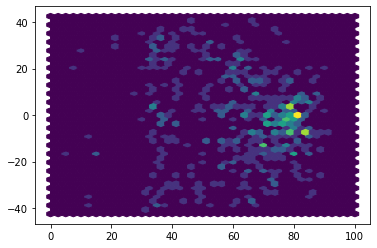

'Now working on Goals'

56

477

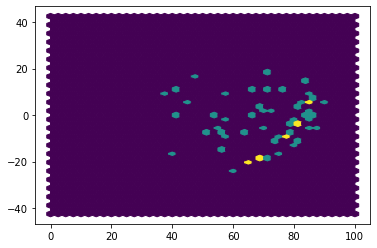

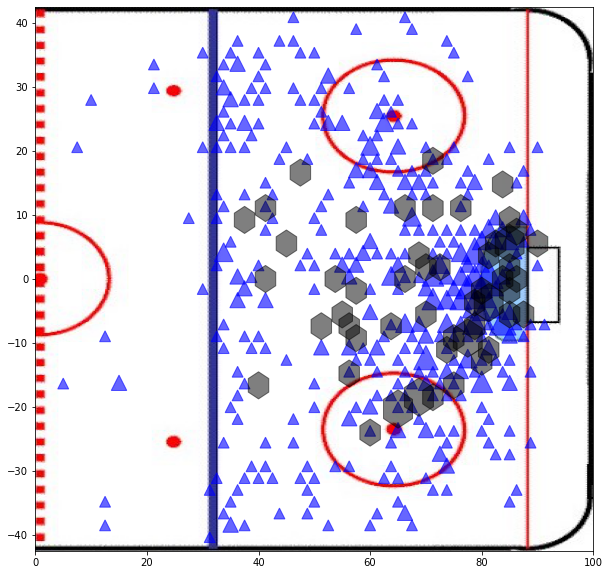

In [8]:
team_a = "Toronto Maple Leafs" 
team_b = "Ottawa Senators"

filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe)
print(filtered_dataframe.shape)

shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe)
shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(shots_from_filtered_dataframe, goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values)


## Defence Positions

,coor_x,coor_y,event_type,coor_x_normalized,coor_y_normalized,game_id,shooting_team,shooting_team_home_or_away,shot_goal_defending_team
0,85.0,-1.0,Goal,85.0,-1.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
1,-32.0,-2.0,Shot,32.0,2.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
2,63.0,-6.0,Shot,63.0,-6.0,2019020001,Ottawa Senators,Away,Toronto Maple Leafs
3,-59.0,-20.0,Shot,59.0,20.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
4,-42.0,-29.0,Shot,42.0,29.0,2019020001,Toronto Maple Leafs,Home,Ottawa Senators
...,...,...,...,...,...,...,...,...,...
165666,-80.0,23.0,Shot,80.0,-23.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators
165667,72.0,-18.0,Shot,72.0,-18.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165668,68.0,14.0,Shot,68.0,14.0,2021020567,Ottawa Senators,Away,Toronto Maple Leafs
165669,-57.0,2.0,Goal,57.0,-2.0,2021020567,Toronto Maple Leafs,Home,Ottawa Senators


The goal conversion ratio of 'Ottawa Senators' against 'Toronto Maple Leafs' is 10.02%


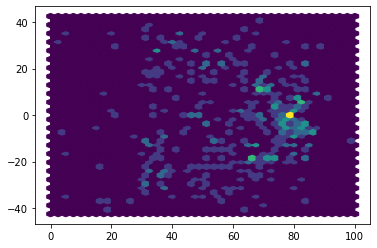

'Now working on Goals'

42

377

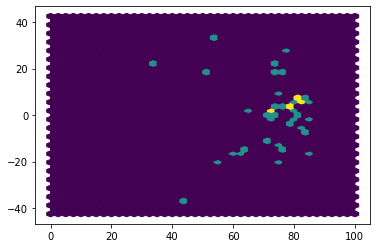

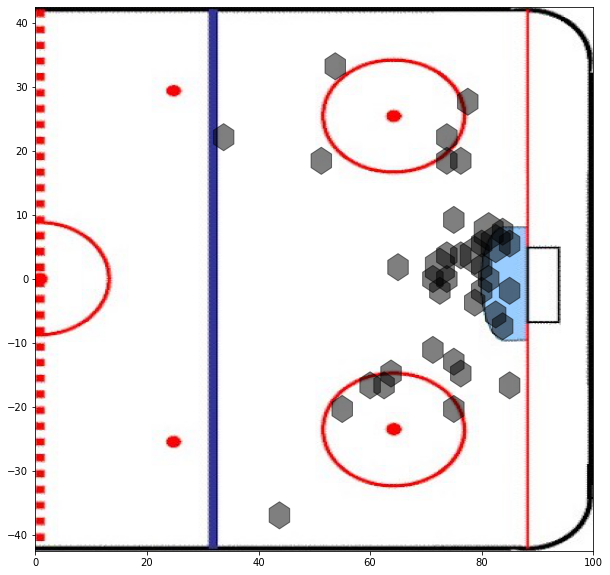

In [5]:
team_b, team_a = team_a, team_b
filtered_dataframe = display_dataset(team_a, team_b, shot_goals_dataframe)
shots_from_filtered_dataframe, goals_from_filtered_dataframe = calculate_goal_conversion_ratio(team_a, team_b, filtered_dataframe)
shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values = plot_hexbin_shots_goals(shots_from_filtered_dataframe, goals_from_filtered_dataframe)
plot_shots_goals_on_rink(shots_hexbin_offsets, shots_hexbin_values, goals_hexbin_offsets, goals_hexbin_values, False)

## Player statistics for top 4 players

## Save data for visualization